# **Paul Golder - Capstone Project March 2025**
# **Data Extract and Combine

## Objectives

* Import data downloaded from "Kaggle" - review it , clean it, combine it into one file with flags to identify false or true.

## Inputs

* CSV files in source_data files

## Outputs

* csv file in cleaned_data called combined_clean_step1.csv

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 

---

# Change working directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'h:\\VScode\\CapStoneProject_2025-1\\3_data_extract_combine'

In [3]:
# check current directory contains the file README.md
if os.path.exists("README.md"):
    print("The file README.md exists in the current directory")
else:
    print("The file README.md does not exist in the current directory")
    print("You are in the directory: ", current_dir)
    print("Changing current directory to its parent directory")
    os.chdir(os.path.dirname(current_dir))
    print("You set a new current directory")
    current_dir = os.getcwd()
    if os.path.exists("README.md"):
        print("The file README.md exists in the current directory")
    else:
        RuntimeError("The file README.md does not exist in the current directory, please check the current directory")
        print("Current Directory =", current_dir)

The file README.md does not exist in the current directory
You are in the directory:  h:\VScode\CapStoneProject_2025-1\3_data_extract_combine
Changing current directory to its parent directory
You set a new current directory
The file README.md exists in the current directory


# Load data from files into Pandas dataframes

Section 1 content

In [37]:

import pandas as pd
import re
from sklearn.pipeline import Pipeline


def dataload():
    # load the data
    fake_df = pd.read_csv("source_data/fake.csv")
    true_df = pd.read_csv("source_data/true.csv")
    return fake_df, true_df

def classify_and_combine(true_df, fake_df):
    # add a column to each dataframe to indicate whether the news is fake or true
    true_df["label"] = 1
    fake_df["label"] = 0
    #update fake_df index column by 100000 to avoid index duplication
    fake_df.index = fake_df.index + 100000
    # combine the two dataframes
    combined_df = pd.concat([true_df, fake_df])
    # rename the text colum "article_text"
    combined_df.rename(columns={"text":"article_text"}, inplace=True)
    # reset the index
    combined_df.reset_index(drop=True, inplace=True)
    return combined_df

# Function to extract the location, source, and remove the text
def extract_source_and_clean(text):
    # Define the regex pattern to match the source (location + source in parentheses + hyphen)
    pattern = r'^[A-Za-z\s,/.]+ \([A-Za-z]+\) -'  # Match location, source in parentheses, and hyphen
    match = re.match(pattern, text)
    
    if match:
        # Extract the matched portion (location + source + hyphen)
        source = match.group(0).strip()
        
        # Remove the matched portion from the original text to get the cleaned text
        cleaned_text = text.replace(source, '').strip()
        
        return source, cleaned_text
    else:
        return '', text

# Function to split the source into location and source, removing the parentheses around the source
def split_location_and_source(source):
    if source:
        try:
            # Ensure the source is in the expected format before attempting regex matching
            if "(" not in source or ")" not in source:
                return '', ''  # No valid source found

            # Updated regex to handle more complex locations and sources
            location_match = re.match(r'^[A-Za-z\s,/.&\-0-9]+', source)
            source_name_match = re.match(r'\([A-Za-z0-9/\-\s]+\)', source)
            
            # If both location and source matches are found
            if location_match and source_name_match:
                location = location_match.group(0).strip()  # Extract the location
                source_name = source_name_match.group(0).strip()[1:-1]  # Remove the parentheses from source
                return location, source_name
            else:
                return '', ''  # Return empty if no valid match found
        except Exception as e:
            print(f"Error: {e}")
            # If there is an error, return empty strings
            return 'ERROR', 'ERROR'
    else:
        # If source is empty, return empty strings
        return '', ''

# create a pipeline apply all previous cleansing steps to the data
# this pipeline will be used to transform the data before training the model
# the pipeline will include the following steps:
# 1. Extract the source and clean the text
# 2. Split the location and source
# 3. Standardise the title length and article text length

def data_pipeline():
    #  Pipeline to transform the data
    fake_df, true_df = dataload()
    # Combine the dataframes
    combined_df = classify_and_combine(true_df, fake_df)
    # Extract the source and clean the text
    combined_df[['source', 'cleaned_text']] = combined_df['article_text'].apply(lambda x: pd.Series(extract_source_and_clean(x)))
    # Replace empty source with 'UNKNOWN (Unknown) -'
    combined_df['source'].replace('', 'UNKNOWN (Unknown) -', inplace=True)
    combined_df['source'].fillna('UNKNOWN (Unknown) -', inplace=True)
    combined_df['source'].replace('-','' , inplace=True)
    #remove excess spaces all columns
    combined_df = combined_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    #split the source into location and source name
    combined_df[['location', 'source_name']] = combined_df['source'].apply(split_location_and_source).apply(pd.Series)
    combined_df['location'] = combined_df['location'].fillna('UNKNOWN')
    combined_df['source_name'] = combined_df['source_name'].fillna('Unknown')
    combined_df['title_length'] = combined_df['title'].apply(len)
    combined_df['text_length'] = combined_df['cleaned_text'].apply(len)
    return combined_df

In [38]:
# Generate Combined Data and save as a csv file
combined_df = data_pipeline()
# check for any blank values
print(combined_df.isnull().sum())
# if no blank or null values in title, article_text, date, label, subject then export to csv
if combined_df.isnull().sum().sum() == 0:
    combined_df.to_csv("data/combined_data.csv", index=False)
    print("Data has been cleaned and saved as combined_data.csv in the data folder")
else:
    print("There are still missing values in the data")

# return all rows with missing values
missing_values = combined_df[combined_df.isnull().any(axis=1)]


title           0
article_text    0
subject         0
date            0
label           0
source          0
cleaned_text    0
location        0
source_name     0
title_length    0
text_length     0
dtype: int64
Data has been cleaned and saved as combined_data.csv in the data folder


In [39]:
# list all rows with an article_text length of 0
zero_text_length = combined_df[combined_df['text_length'] == 0]
print(f"Number of rows with text_length of 0: {len(zero_text_length)}")
# set article_text to contents of title if article_text is empty or lenght is 0
combined_df['cleaned_text'] = combined_df.apply(lambda x: x['title'] if x['text_length'] == 0 else x['cleaned_text'], axis=1)
# update text_length to reflect the new text
combined_df['text_length'] = combined_df['cleaned_text'].apply(len)
# check for any blank values
print(combined_df.isnull().sum())

# Check the length of the article_text field for row 8970
article_text_length = len(combined_df.loc[8970, 'article_text'])
print(f"Length of article_text for row 8970: {article_text_length}")

# Print the actual content of the article_text field for row 8970
print(f"Content of article_text for row 8970: '{combined_df.loc[8970, 'article_text']}'")


Number of rows with text_length of 0: 631
title           0
article_text    0
subject         0
date            0
label           0
source          0
cleaned_text    0
location        0
source_name     0
title_length    0
text_length     0
dtype: int64
Length of article_text for row 8970: 0
Content of article_text for row 8970: ''


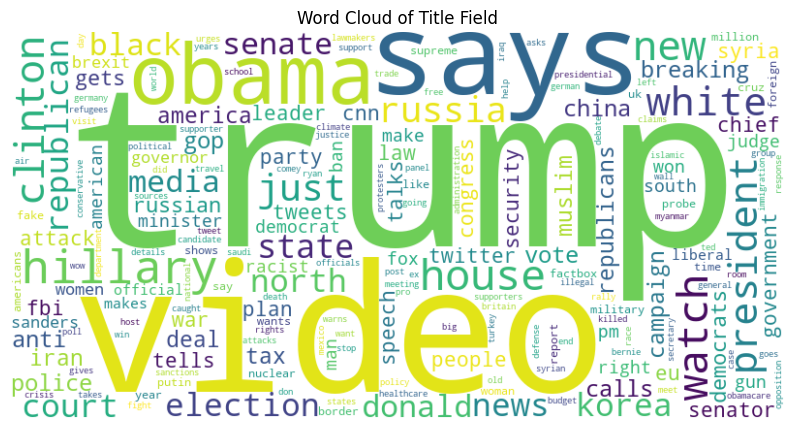

In [ ]:
# create a word cloud of the most common words in the title field - exclude stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

# Create a word cloud of the most common words in the title field
# Exclude stopwords from the word cloud
stopwords = ENGLISH_STOP_WORDS
# comvert stopwords to a list
stopwords = list(stopwords)
# Create a CountVectorizer object
vectorizer = CountVectorizer(stop_words=stopwords)
# Fit and transform the title field
title_vector = vectorizer.fit_transform(combined_df['title'])
# Get the feature names
feature_names = vectorizer.get_feature_names_out()
# Get the word counts
word_counts = title_vector.toarray().sum(axis=0)
# Create a dictionary of word counts
word_count_dict = dict(zip(feature_names, word_counts))
# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_count_dict)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Title Field')
plt.show()


In [4]:
# import csv from dataset_Misinfo_fake.zip
import pandas as pd
import os
# Define the path to the dataset zip file
current_dir = os.getcwd()

print(current_dir)

# Load the csv files into a pandas dataframe, using a ; as a delimiter

dfs = []

Filefilename = "2_source_data\\DataSet_Misinfo_FAKE.zip"

df = pd.read_csv(Filefilename, delimiter=',', compression='zip')
dfs.append(df)

# Combine the dataframes
combined_df = pd.concat(dfs)
# Reset the index
combined_df.reset_index(drop=True, inplace=True)
# Display the first few rows of the combined dataframe
combined_df.head()

# add a column to the dataframe to indicate whether the news is fake or true
combined_df["label"] = 0

# extract 1st sentence from article_text and add it to a new column "title"
combined_df['title'] = combined_df['text'].str.split('.').str[0]

# create column called "subject" and set it to "UNKNOWN"
combined_df['subject'] = "UNKNOWN"

# create a column called "date" and set it to "None" 
combined_df['date'] = "None"

# drop the #Unnamed: 0 column
combined_df.drop(columns=['Unnamed: 0'], inplace=True)
#save file and append to fake.csv
combined_df.to_csv("data/fake_misinfo.csv", mode='a', header=False, index=False)
print("Data has been appended to fake.csv in the data folder")


# import csv from dataset_Misinfo_fake.zip
import pandas as pd
import os
# Define the path to the dataset zip file
current_dir = os.getcwd()

print(current_dir)

# Load the csv files into a pandas dataframe, using a ; as a delimiter

dfs = []

Filefilename = "2_source_data\\DataSet_Misinfo_TRUE.zip"

df = pd.read_csv(Filefilename, delimiter=',', compression='zip')
dfs.append(df)

# Combine the dataframes
combined_df = pd.concat(dfs)
# Reset the index
combined_df.reset_index(drop=True, inplace=True)
# Display the first few rows of the combined dataframe
combined_df.head()

# add a column to the dataframe to indicate whether the news is fake or true
combined_df["label"] = 0

# extract 1st sentence from article_text and add it to a new column "title"
combined_df['title'] = combined_df['text'].str.split('.').str[0]

# create column called "subject" and set it to "UNKNOWN"
combined_df['subject'] = "UNKNOWN"

# create a column called "date" and set it to "None" 
combined_df['date'] = "None"

# drop the #Unnamed: 0 column
combined_df.drop(columns=['Unnamed: 0'], inplace=True)
#save file and append to fake.csv
combined_df.to_csv("data/true_misinfo.csv", mode='a', header=False, index=False)
print("Data has been appended to true.csv in the data folder")

# Load the csv files into a pandas dataframe, using a ; as a delimiter

dfs = []

Filefilename = "2_source_data\\EXTRA_RussianPropagandaSubset.zip"

df = pd.read_csv(Filefilename, delimiter=',', compression='zip')
dfs.append(df)

# Combine the dataframes
combined_df = pd.concat(dfs)
# Reset the index
combined_df.reset_index(drop=True, inplace=True)
# Display the first few rows of the combined dataframe
combined_df.head()

# add a column to the dataframe to indicate whether the news is fake or true
combined_df["label"] = 1

# extract 1st sentence from article_text and add it to a new column "title"
combined_df['title'] = combined_df['text'].str.split('.').str[0]

# create column called "subject" and set it to "UNKNOWN"
combined_df['subject'] = "UNKNOWN"

# create a column called "date" and set it to "None" 
combined_df['date'] = "None"

# drop the #Unnamed: 0 column
combined_df.drop(columns=['Unnamed: 0'], inplace=True)
#save file and append to fake.csv
combined_df.to_csv("data/fake_misinfo.csv", mode='a', header=False, index=False)
print("Data has been appended to fake.csv in the data folder")


h:\VScode\CapStoneProject_2025-1
Data has been appended to fake.csv in the data folder
h:\VScode\CapStoneProject_2025-1
Data has been appended to true.csv in the data folder
Data has been appended to fake.csv in the data folder
